###  MicroGrad demo

In [2]:
#!pip install micrograd
#!pip install scikit-learn

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [4]:
# Seed pour pouvoir reproduire les résultats
np.random.seed(1337)
random.seed(1337)

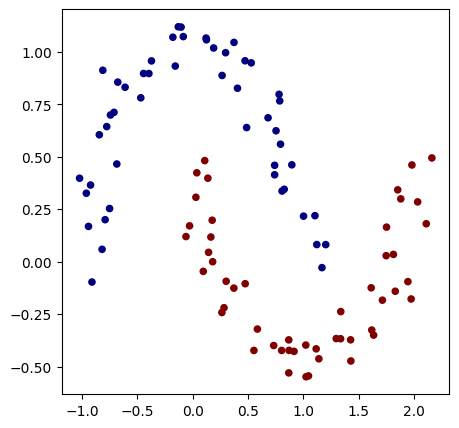

In [5]:
# création du dataset (dataset moon)

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# Visualisation du dataset en 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [6]:
# Creation d'un modèle de 2 couches  
model = MLP(2, [16, 16, 1]) # 2 couches cachées de 16 neurones
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
# Fonction de perte (loss)
def loss(batch_size=None):
    
    # Permet de traiter en batch ou non, avec permutation aléatoire
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    # map permet d'appliquer Value à chaque élément de la liste
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # on applique le modèle à chaque entrées
    scores = list(map(model, inputs))
    
    # on calcule la perte (svm max-margin loss)
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # On applique une régularisation L2
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # On récupère la précision du modèle en plus du loss
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [15]:
# On optimise le modèle avec la descente de gradient stochastique
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 1.4685917829173556, accuracy 49.0%
step 1 loss 0.8928663245908091, accuracy 50.0%
step 2 loss 0.81867496281009, accuracy 70.0%
step 3 loss 0.7042295404971071, accuracy 67.0%
step 4 loss 0.539262007434332, accuracy 78.0%
step 5 loss 0.3873343752864074, accuracy 84.0%
step 6 loss 0.3002090298074754, accuracy 85.0%


(-1.548639298268643, 1.951360701731357)

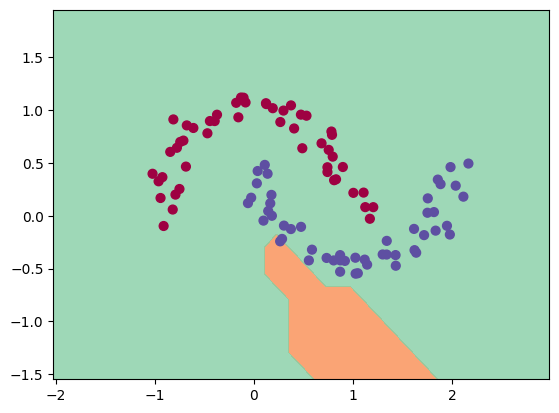

In [14]:
# Visualisation de la frontière de décision

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
